In [1]:
import sys
# sys.stdout = open('logfile', 'w')
sys.path.append('..')

import attack
import data_loader as dl

In [2]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt

# Raw Data

In [4]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_freemove(data_type='raw', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=200,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=50,
                                                                                       upper_quantile_length=0.95,
                                                                                       hide_test_users=False)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading raw freemove geojson file...
Done.
Number of trajectories in loaded dataset: 1197
Number of users in loaded dataset: 74


In [5]:
# Parameters
LCSS_EPS = 200
LCSS_FLIP = True

HL_SP_START_TIME = '6:00'
HL_SP_END_TIME = '10:00'
HL_EP_START_TIME = '18:00'
HL_EP_END_TIME = '0:00'

CHAINING_INFLOW_HR_DIFF_THRESHOLD = 4
CHAINING_HR_DIFF_THRESHOLD = 8

HL_SP_OUTFLOW_THRESHOLD = 2
HL_EP_OUTFLOW_THRESHOLD = 4

RANDOMIZED_SIMULTANEOUS_SEARCH_ITERATIONS = 1000

SIM_THRESH_FOR_NO_MATCH_TRIPS = 0.5

# JSD Parameters
GRID_RESOLUTION_JSD = 1000

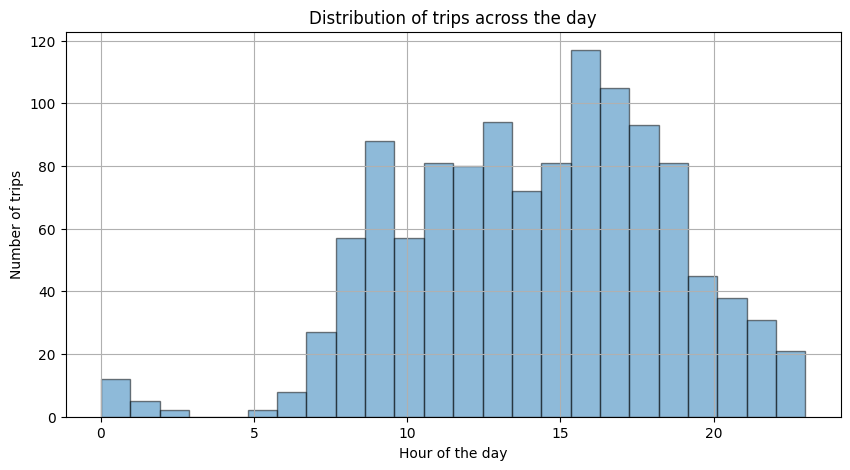

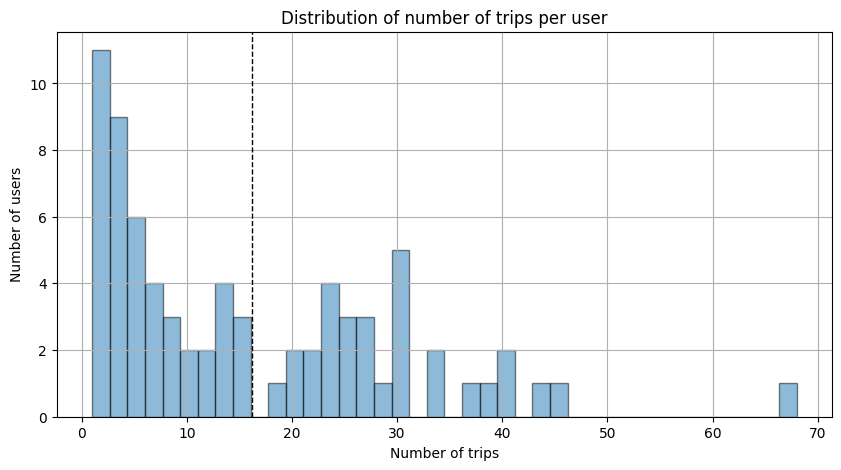

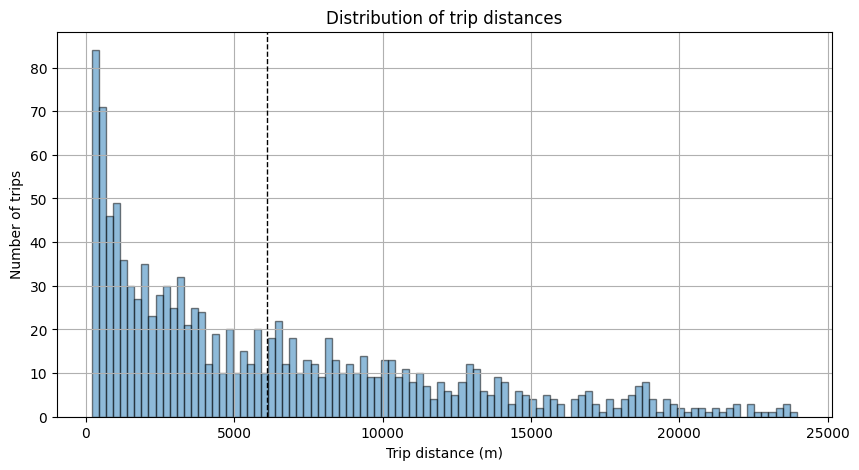

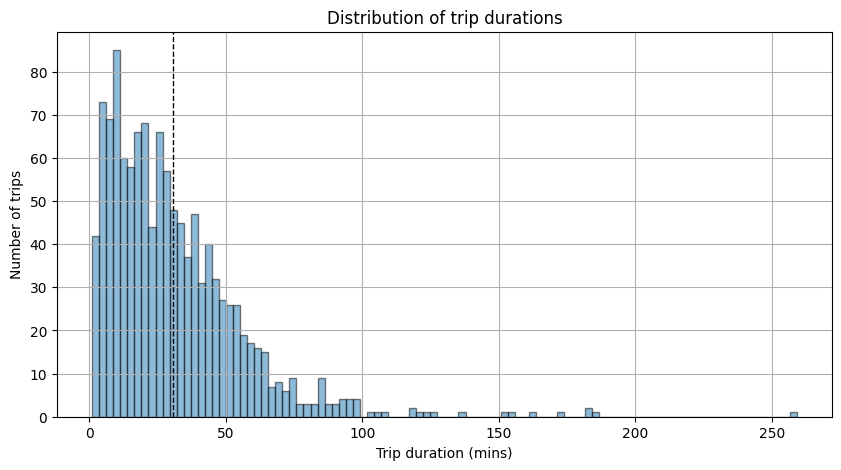


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 1186
Number of trips outside and therefore dropped: 11
Done.

Building mapping of trip chains...


100%|███████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:17<00:00, 66.34it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 345
Number of wrong matches: 12
Done.

Building trip chains...


100%|████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:00<00:00, 42889.43it/s]


Done.

Merging trips...


100%|██████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:11<00:00, 106.32it/s]


Done.
Number of trips that were matched at least once: 1174/1186
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 853
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 88 disconnected components.
 There are 56 islands with ids: 0, 1, 2, 3, 10, 11, 12, 17, 18, 19, 20, 21, 22, 41, 45, 46, 49, 50, 51, 52, 66, 72, 73, 76, 77, 78, 79, 85, 86, 87, 88, 90, 91, 92, 94, 103, 104, 113, 120, 122, 123, 124, 139, 146, 147, 148, 149, 152, 162, 163, 164, 169, 170, 171, 174, 177.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 177 disconnected components.
 There are 106 islands with ids: 0, 6, 22, 23, 26, 27, 35, 36, 37, 40, 44, 45, 46, 51, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 84, 86, 87, 88, 89, 102, 109, 117, 122, 133, 137, 140, 141, 142, 150, 154, 156, 157, 158, 159, 162, 163, 165, 171, 172, 176, 185, 186, 188, 192, 193, 196, 202, 203, 204, 205, 208, 212, 217, 218, 219, 220, 223, 228, 229, 231, 232, 233, 234, 235, 240, 243, 244, 247, 265, 268, 280, 281, 284, 287, 290, 291, 294, 295, 296, 297, 298, 299, 313, 319, 323, 329, 332, 341, 342, 343, 349, 350, 353, 354.
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 213 disconnected components.
 There are 120 islands with ids: 0, 6, 22, 23, 26, 27, 35, 37, 40, 44, 45, 46, 55, 65, 66, 68, 72, 73, 75, 

Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  65
Number of unique HL tiles: 213
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 174/853
Number of trajectories (concatenated) that start AND end in a HL tile: 234/853
Number of trips that match different HL tiles with their SP and EP: 112
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 out of 224 | elapsed:   29.2s remaining:    3.5s
[Parallel(n_jobs=-4)]: Done 224 out of 224 | elapsed:   32.7s finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-4)]: Done 853 out of 853 | elapsed:  1.7min finished


Done.

Building clustering after HL matching step...


 51%|█████████████████████████████████████████                                        | 72/142 [00:00<00:00, 113.13it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 37 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.8s finished
 60%|█████████████████████████████████████████████████                                 | 85/142 [00:01<00:01, 35.07it/s]

Done. Length of longest subset:  27


100%|█████████████████████████████████████████████████████████████████████████████████| 142/142 [00:01<00:00, 73.25it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 853
Homogeneity: 0.997
Completeness: 0.592
V-measure: 0.742
Rand index: 0.978
ARI: 0.059
MI: 3.919
NMI: 0.742
AMI: 0.239
Cluster accuracy: 0.158

Clustering results after HL matching step:
Number of unique clusters: 336
Homogeneity: 0.936
Completeness: 0.732
V-measure: 0.822
Rand index: 0.984
ARI: 0.507
MI: 3.681
NMI: 0.822
AMI: 0.670
Cluster accuracy: 0.557


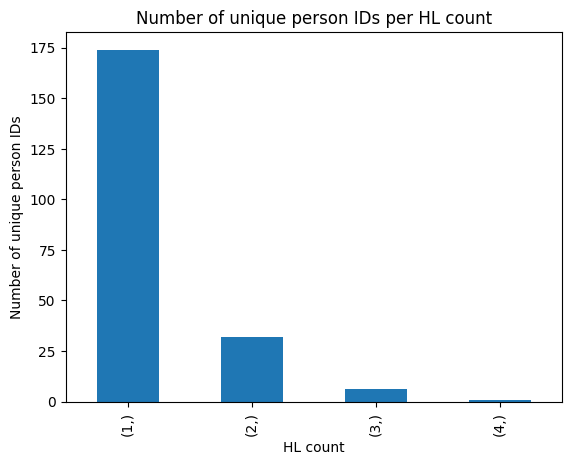

In [5]:
# Run attack non-private data
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [6]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/freemove/freemove_clustering_HL.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Obfuscated Data

In [ ]:
# Load preprocessed private data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_freemove(data_type='private', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=200,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=50,
                                                                                       upper_quantile_length=0.95,
                                                                                       hide_test_users=False)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

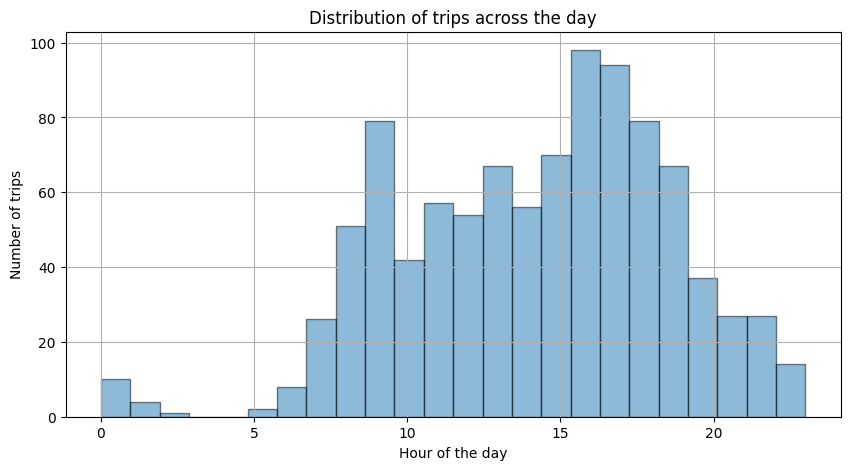

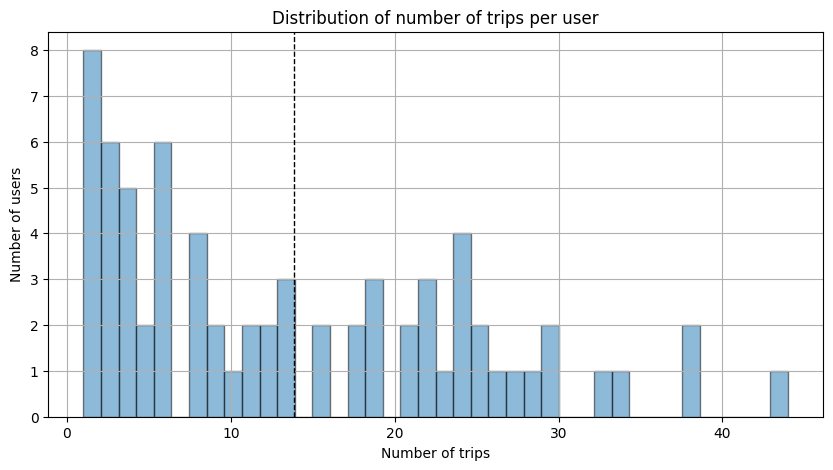

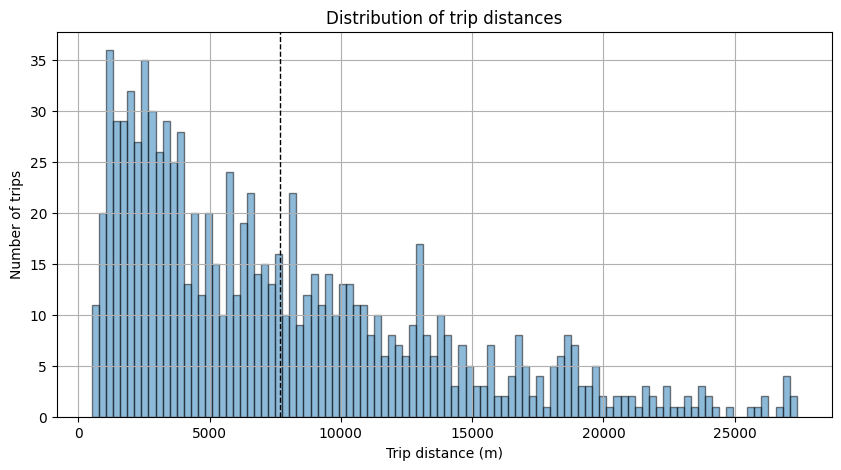

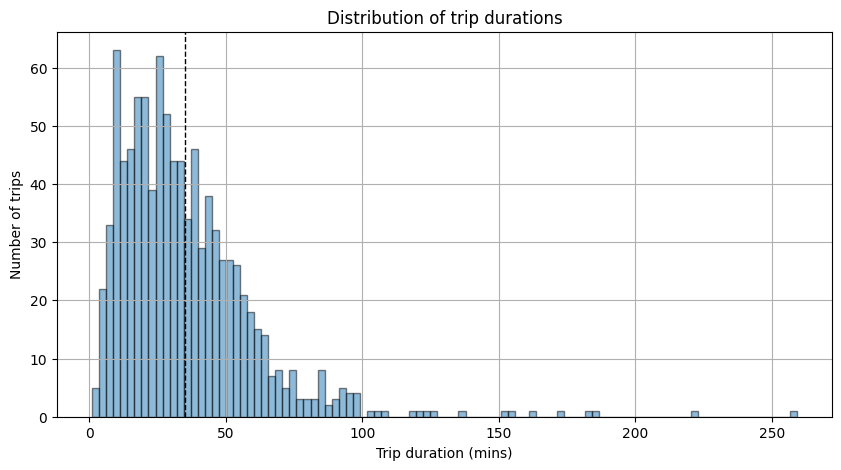


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 961
Number of trips outside and therefore dropped: 9
Done.

Building mapping of trip chains...


100%|█████████████████████████████████████████████████████████████████████████████████| 961/961 [00:17<00:00, 54.28it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 77
Number of wrong matches: 12
Done.

Building trip chains...


100%|█████████████████████████████████████████████████████████████████████████████| 961/961 [00:00<00:00, 218384.69it/s]


Done.

Merging trips...


100%|█████████████████████████████████████████████████████████████████████████████████| 961/961 [00:13<00:00, 72.21it/s]


Done.
Number of trips that were matched at least once: 960/961
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 885
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 96 disconnected components.
 There are 73 islands with ids: 0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 33, 34, 35, 38, 39, 40, 44, 51, 54, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 87, 88, 89, 100, 102, 103, 104, 114, 115, 126, 130, 131, 132, 133, 143, 147, 148, 151, 153, 154, 155, 156, 157, 158, 159.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 198 disconnected components.
 There are 138 islands with ids: 0, 1, 2, 5, 11, 17, 18, 21, 22, 26, 27, 28, 29, 32, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 53, 58, 59, 60, 61, 63, 65, 68, 69, 71, 72, 74, 79, 82, 88, 89, 90, 95, 98, 109, 116, 117, 118, 119, 120, 121, 126, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 146, 151, 152, 159, 161, 162, 167, 171, 172, 174, 175, 176, 179, 183, 184, 186, 188, 194, 198, 199, 202, 204, 205, 207, 208, 210, 211, 212, 213, 215, 216, 217, 218, 225, 228, 229, 230, 234, 236, 237, 239, 241, 242, 243, 244, 245, 246, 247, 248, 251, 254, 255, 259, 262, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 276, 277, 284, 286, 289, 291, 296, 297, 301, 302, 303.
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 T

Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  62
Number of unique HL tiles: 246
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 260/885
Number of trajectories (concatenated) that start AND end in a HL tile: 110/885
Number of trips that match different HL tiles with their SP and EP: 85
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done  92 out of 170 | elapsed:   23.5s remaining:   19.9s
[Parallel(n_jobs=-4)]: Done 170 out of 170 | elapsed:   34.0s finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-4)]: Done 885 out of 885 | elapsed:  2.4min finished


Done.

Building clustering after HL matching step...


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 251.27it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 885
Homogeneity: 0.995
Completeness: 0.579
V-measure: 0.732
Rand index: 0.978
ARI: 0.013
MI: 3.911
NMI: 0.732
AMI: 0.060
Cluster accuracy: 0.106

Clustering results after HL matching step:
Number of unique clusters: 468
Homogeneity: 0.928
Completeness: 0.649
V-measure: 0.764
Rand index: 0.980
ARI: 0.283
MI: 3.646
NMI: 0.764
AMI: 0.441
Cluster accuracy: 0.357


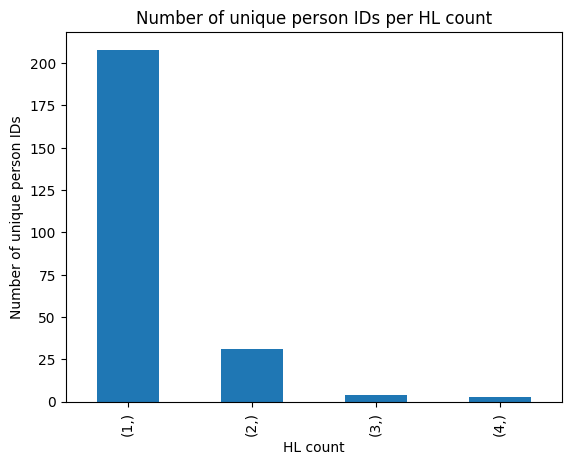

In [7]:
# Run attack private data
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [8]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/freemove/freemove_clustering_HL_private.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Raw (500m grid)

In [14]:
# Load preprocessed data with big tessellation 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_freemove(data_type='raw', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=500,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=50,
                                                                                       upper_quantile_length=0.95,
                                                                                       hide_test_users=False)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading raw freemove geojson file...
Done.
Number of trajectories in loaded dataset: 1197
Number of users in loaded dataset: 74


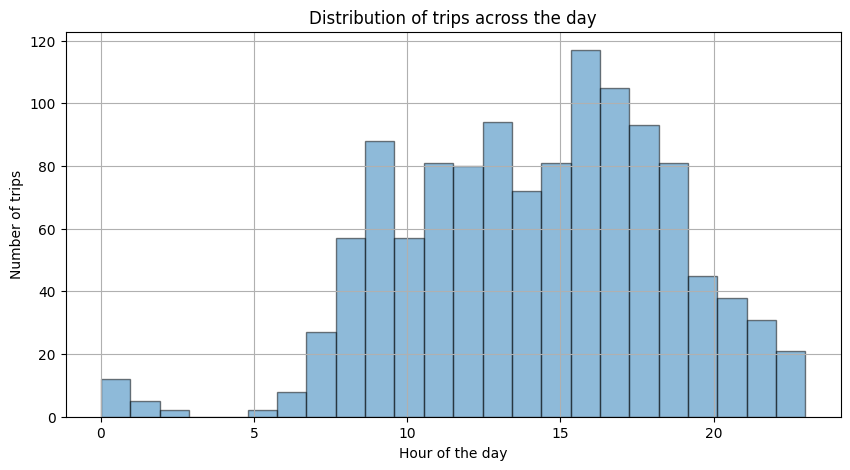

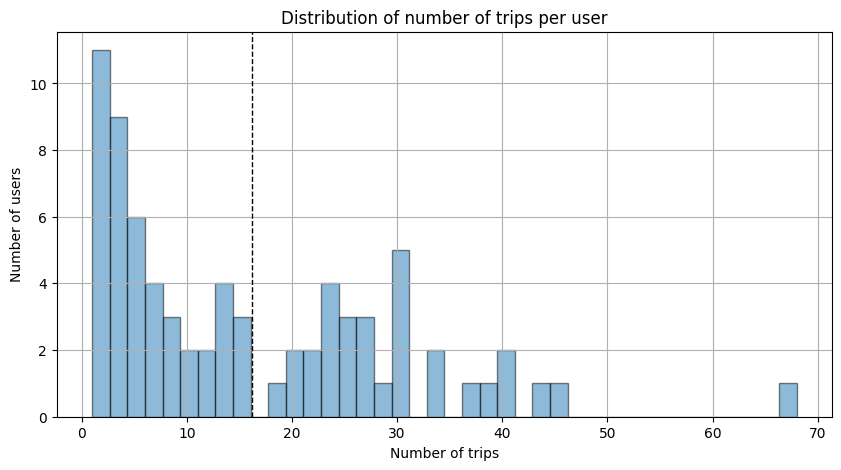

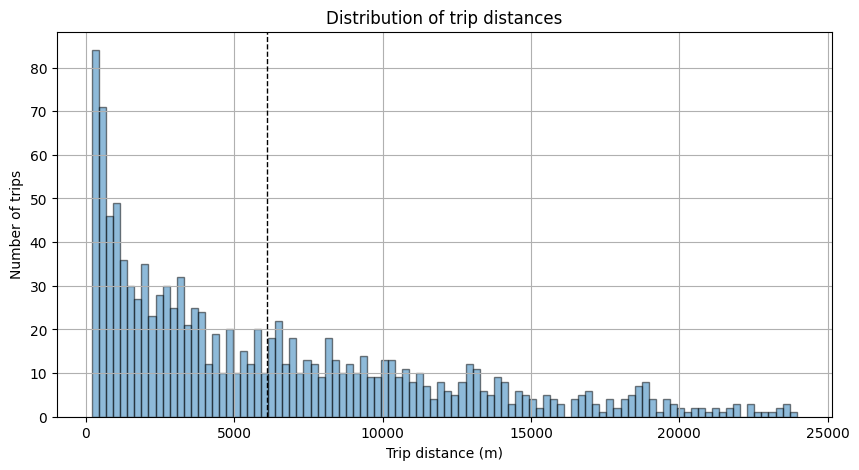

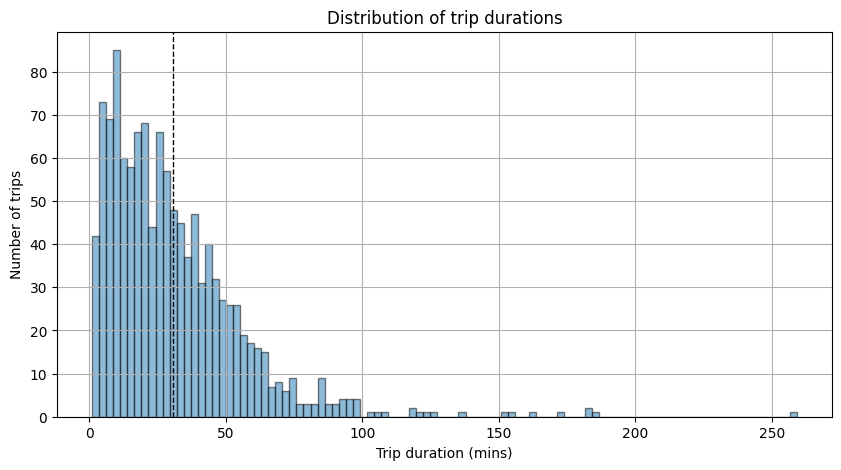


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 1186
Number of trips outside and therefore dropped: 11
Done.

Building mapping of trip chains...


100%|███████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:17<00:00, 67.67it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 404
Number of wrong matches: 18
Done.

Building trip chains...


100%|████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:00<00:00, 33555.34it/s]


Done.

Merging trips...


100%|██████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:10<00:00, 111.11it/s]


Done.
Number of trips that were matched at least once: 1166/1186
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 802
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 74 disconnected components.
 There are 40 islands with ids: 0, 1, 2, 3, 10, 15, 16, 21, 22, 46, 49, 50, 51, 52, 72, 73, 76, 83, 87, 91, 102, 106, 113, 114, 122, 138, 139, 146, 147, 148, 151, 152, 162, 163, 164, 165, 170, 171, 174, 177.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 112 disconnected components.
 There are 49 islands with ids: 0, 13, 23, 26, 27, 30, 31, 37, 38, 44, 45, 46, 47, 56, 68, 73, 86, 87, 139, 155, 156, 163, 165, 166, 185, 186, 196, 209, 220, 233, 258, 268, 282, 290, 293, 294, 299, 313, 319, 326, 327, 332, 341, 342, 343, 349, 350, 353, 354.
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 125 disconnected components.
 There are 51 islands with ids: 0, 14, 23, 26, 27, 30, 37, 38, 45, 46, 80, 81, 90, 139, 155, 156, 170, 224, 225, 251, 268, 284, 290, 297, 298, 299, 319, 326, 332, 342, 343, 349, 350, 353, 356, 357, 358, 365, 373, 377, 401, 405, 406, 431, 441, 457, 476, 501, 507, 519, 529.
  warnings.warn(message)


Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  65
Number of unique HL tiles: 125
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 82/802
Number of trajectories (concatenated) that start AND end in a HL tile: 373/802
Number of trips that match different HL tiles with their SP and EP: 188
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 376 out of 376 | elapsed:   55.3s finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-4)]: Done 802 out of 802 | elapsed:  1.7min finished


Done.

Building clustering after HL matching step...


  0%|                                                                                            | 0/87 [00:00<?, ?it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 98 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.9s finished
 14%|███████████▍                                                                       | 12/87 [00:01<00:05, 12.60it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  31
Running randomized subset search for 1000 iterations with 41 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.8s finished
 31%|█████████████████████████▊                                                         | 27/87 [00:02<00:03, 16.96it/s]

Done. Length of longest subset:  28


 56%|██████████████████████████████████████████████▋                                    | 49/87 [00:02<00:00, 39.31it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 37 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.7s finished


Done. Length of longest subset:  28


100%|███████████████████████████████████████████████████████████████████████████████████| 87/87 [00:03<00:00, 23.24it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 802
Homogeneity: 0.994
Completeness: 0.597
V-measure: 0.746
Rand index: 0.978
ARI: 0.067
MI: 3.910
NMI: 0.746
AMI: 0.268
Cluster accuracy: 0.164

Clustering results after HL matching step:
Number of unique clusters: 270
Homogeneity: 0.870
Completeness: 0.721
V-measure: 0.789
Rand index: 0.980
ARI: 0.460
MI: 3.423
NMI: 0.789
AMI: 0.635
Cluster accuracy: 0.529


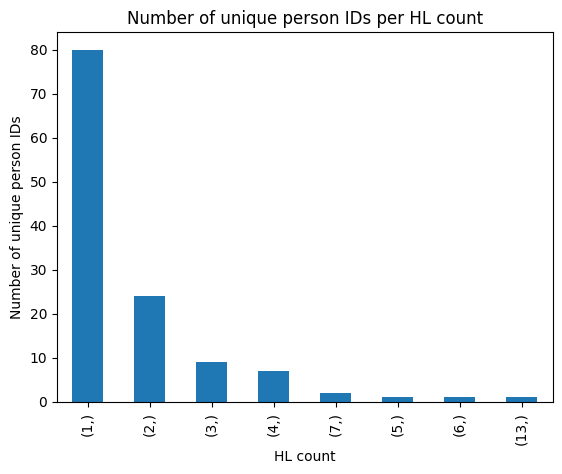

In [15]:
# Run attack private data with larger tessellation
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [16]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/freemove/freemove_clustering_HL_500tessellation.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Obfuscated (500m grid)

In [9]:
# Load preprocessed private data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_freemove(data_type='private', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=500,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=50,
                                                                                       upper_quantile_length=0.95,
                                                                                       hide_test_users=False)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading private freemove geojson file...
Done.
Number of trajectories in loaded dataset: 970
Number of users in loaded dataset: 70


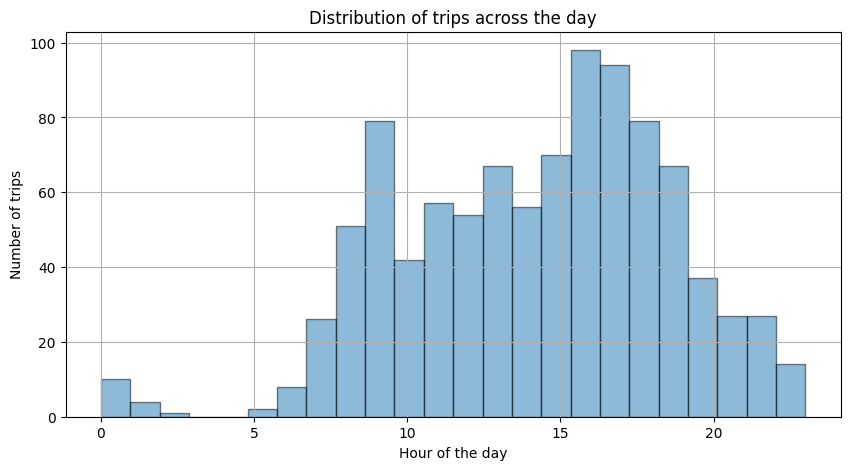

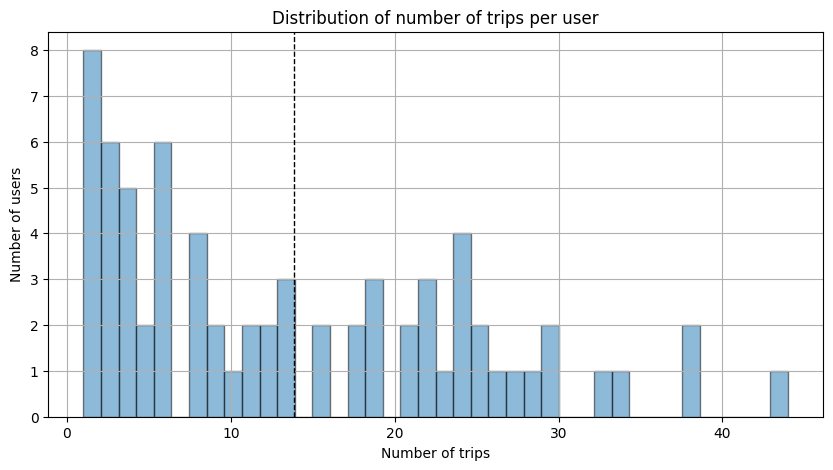

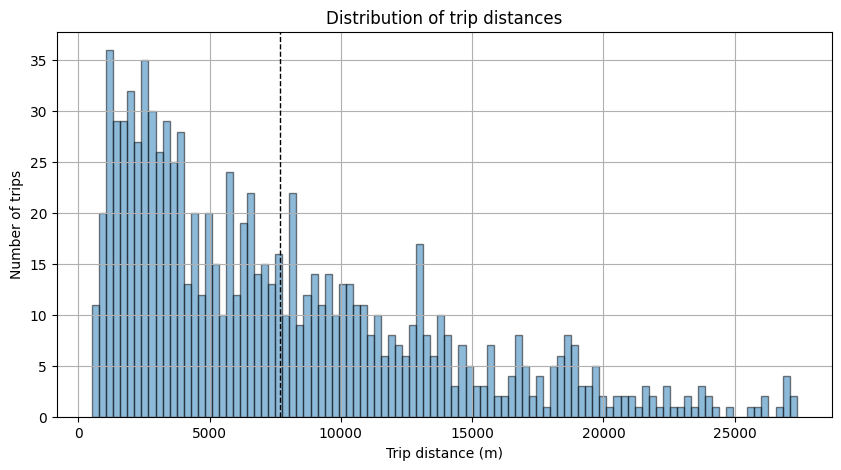

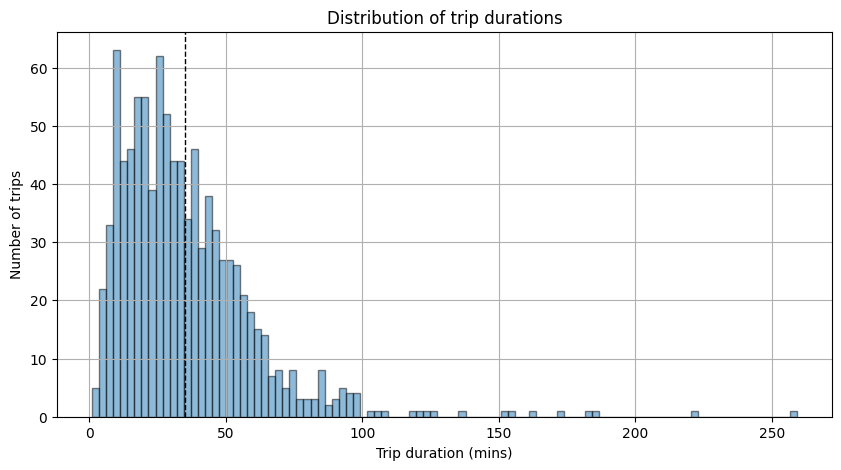


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 961
Number of trips outside and therefore dropped: 9
Done.

Building mapping of trip chains...


100%|█████████████████████████████████████████████████████████████████████████████████| 961/961 [00:14<00:00, 64.74it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 162
Number of wrong matches: 21
Done.

Building trip chains...


100%|██████████████████████████████████████████████████████████████████████████████| 961/961 [00:00<00:00, 79496.80it/s]


Done.

Merging trips...


100%|█████████████████████████████████████████████████████████████████████████████████| 961/961 [00:10<00:00, 93.66it/s]


Done.
Number of trips that were matched at least once: 954/961
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 806
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 68 disconnected components.
 There are 43 islands with ids: 0, 1, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 22, 34, 38, 39, 40, 41, 45, 62, 64, 66, 68, 69, 73, 74, 76, 86, 87, 90, 103, 104, 105, 122, 126, 131, 132, 133, 137, 152, 154, 155, 158.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 100 disconnected components.
 There are 43 islands with ids: 0, 1, 4, 18, 21, 22, 28, 29, 33, 38, 41, 61, 70, 88, 120, 121, 136, 137, 156, 157, 162, 182, 198, 214, 226, 229, 230, 233, 244, 247, 254, 257, 265, 266, 276, 277, 285, 289, 290, 296, 297, 302, 303.
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 113 disconnected components.
 There are 50 islands with ids: 0, 4, 18, 21, 22, 28, 36, 40, 41, 63, 74, 99, 125, 138, 200, 201, 222, 230, 234, 248, 259, 260, 268, 285, 289, 290, 296, 297, 302, 303, 305, 306, 307, 317, 319, 320, 321, 336, 343, 344, 366, 369, 375, 379, 380, 394, 413, 436, 441, 462.
  warnings.warn(message)


Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  62
Number of unique HL tiles: 113
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 122/806
Number of trajectories (concatenated) that start AND end in a HL tile: 238/806
Number of trips that match different HL tiles with their SP and EP: 154
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 308 out of 308 | elapsed:   37.2s finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-4)]: Done 806 out of 806 | elapsed:  1.4min finished


Done.

Building clustering after HL matching step...


  0%|                                                                                            | 0/92 [00:00<?, ?it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 32 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.8s finished
  2%|█▊                                                                                  | 2/92 [00:00<00:37,  2.41it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  28
Running randomized subset search for 1000 iterations with 66 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.8s finished
  4%|███▋                                                                                | 4/92 [00:01<00:36,  2.39it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  27
Running randomized subset search for 1000 iterations with 44 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.7s finished
  8%|██████▍                                                                             | 7/92 [00:02<00:28,  3.00it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  34
Running randomized subset search for 1000 iterations with 38 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.7s finished
 25%|████████████████████▊                                                              | 23/92 [00:03<00:06, 10.41it/s]

Done. Length of longest subset:  26


 50%|█████████████████████████████████████████▌                                         | 46/92 [00:03<00:01, 28.76it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 1000 iterations with 36 trajectories...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:    0.6s finished
 80%|██████████████████████████████████████████████████████████████████▊                | 74/92 [00:04<00:00, 31.10it/s]

Done. Length of longest subset:  35


100%|███████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 20.53it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 806
Homogeneity: 0.993
Completeness: 0.588
V-measure: 0.739
Rand index: 0.978
ARI: 0.030
MI: 3.902
NMI: 0.739
AMI: 0.129
Cluster accuracy: 0.130

Clustering results after HL matching step:
Number of unique clusters: 296
Homogeneity: 0.840
Completeness: 0.686
V-measure: 0.755
Rand index: 0.978
ARI: 0.397
MI: 3.300
NMI: 0.755
AMI: 0.536
Cluster accuracy: 0.439


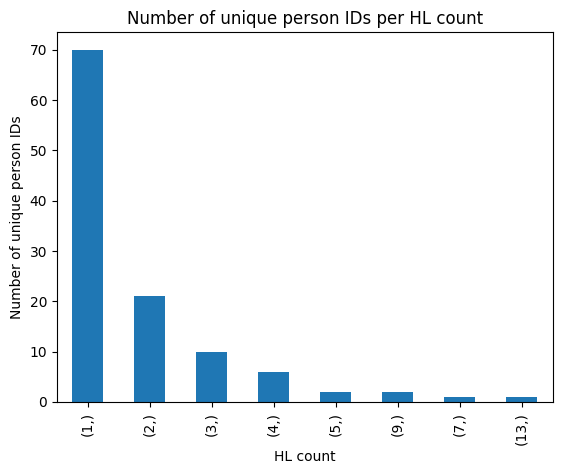

In [10]:
# Run attack private data with larger tessellation
attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [11]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/freemove/freemove_clustering_HL_private_500tessellation.geojson', driver="GeoJSON")

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [12]:
for cl_id in full_trip_gdf.clustering_HL.unique():
    if find_nr_overlaps(cl_id,cl_id, full_trip_gdf) > 0:
        print(cl_id)
        print("error")

Overlapping trips in two clusters! Not merging these...
187 171
149
error


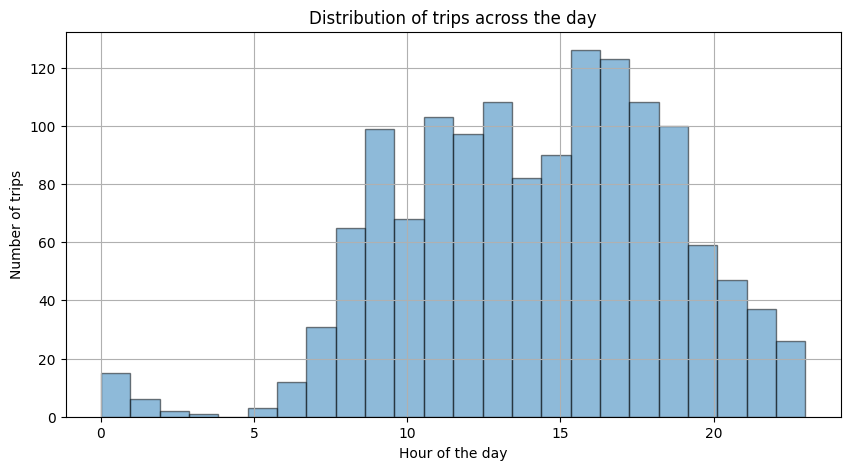

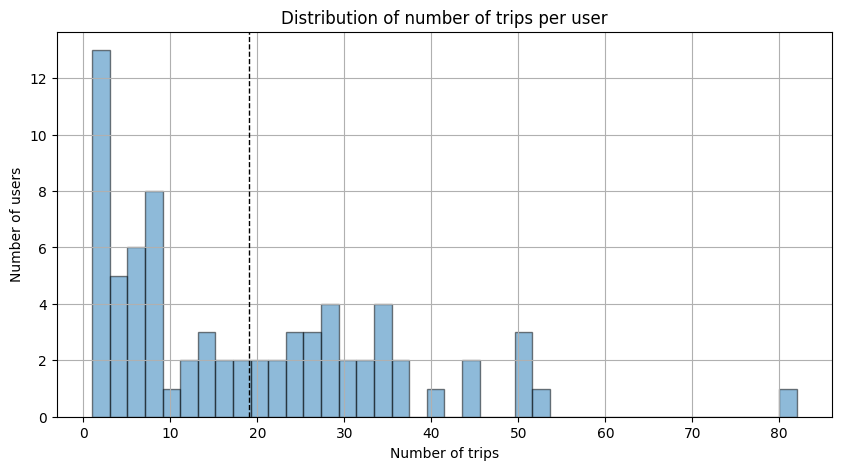

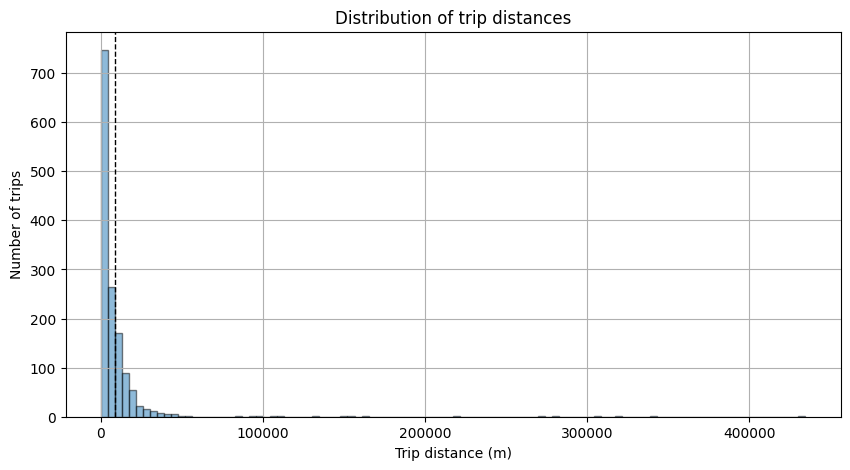

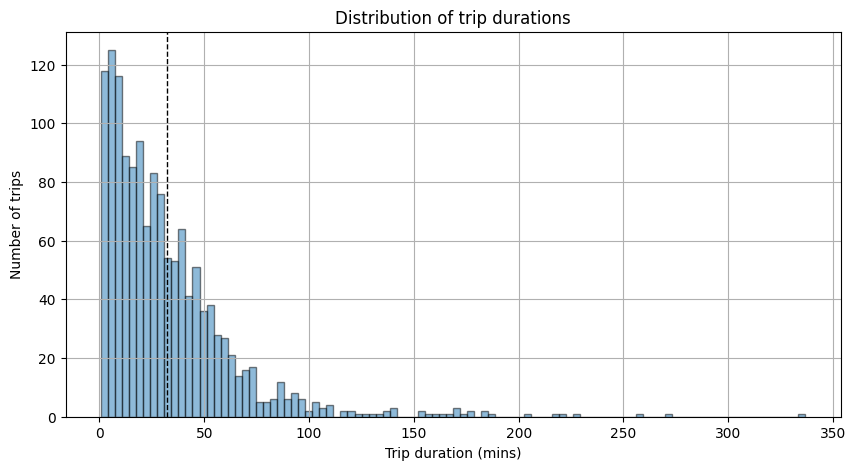


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 1375
Number of trips outside and therefore dropped: 33
Done.

Building mapping of trip chains...


100%|███████████████████████████████████████████████████████████████████████████████| 1375/1375 [00:16<00:00, 82.74it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 476
Number of wrong matches: 20
Done.

Building trip chains...


100%|████████████████████████████████████████████████████████████████████████████| 1375/1375 [00:00<00:00, 27038.33it/s]


Done.

Merging trips...


100%|██████████████████████████████████████████████████████████████████████████████| 1375/1375 [00:12<00:00, 114.03it/s]


Done.
Number of trips that were matched at least once: 1358/1375
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 916
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 81 disconnected components.
 There are 46 islands with ids: 1, 4, 5, 6, 24, 29, 33, 37, 38, 39, 40, 45, 46, 47, 48, 49, 57, 58, 59, 70, 84, 91, 92, 96, 98, 99, 102, 103, 113, 114, 115, 117, 118, 119, 120, 123, 137, 138, 158, 159, 178, 179, 182, 185, 186, 198.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 124 disconnected components.
 There are 51 islands with ids: 4, 23, 37, 50, 51, 52, 53, 59, 60, 98, 115, 116, 126, 127, 129, 130, 132, 136, 148, 150, 156, 157, 158, 167, 199, 200, 203, 218, 225, 226, 239, 241, 244, 245, 262, 263, 269, 300, 302, 317, 318, 321, 329, 347, 355, 357, 387, 392, 406, 414, 422.
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 147 disconnected components.
 There are 59 islands with ids: 7, 68, 106, 144, 145, 147, 154, 155, 204, 238, 239, 246, 247, 259, 265, 273, 276, 291, 292, 295, 306, 313, 322, 323, 326, 337, 356, 357, 367, 368, 369, 370, 383, 390, 391, 408, 409, 420, 421, 437, 463, 468, 472, 474, 482, 484, 485, 497, 498, 531, 532, 537, 538, 543, 557, 564, 573, 592, 613.
  warnings.warn(message)


Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  66
Number of unique HL tiles: 147
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 87/916
Number of trajectories (concatenated) that start AND end in a HL tile: 487/916
Number of trips that match different HL tiles with their SP and EP: 240
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-4)]: Done 480 out of 480 | elapsed:  1.2min finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-4)]: Done 916 out of 916 | elapsed:  2.1min finished


Done.

Building clustering after HL matching step...


 11%|█████████▎                                                                        | 11/97 [00:00<00:00, 102.45it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 400 iterations with 109 trajectories...


[Parallel(n_jobs=-4)]: Done 400 out of 400 | elapsed:    0.6s finished
 29%|███████████████████████▉                                                           | 28/97 [00:00<00:02, 28.51it/s]

Done. Length of longest subset:  24


 41%|██████████████████████████████████▏                                                | 40/97 [00:01<00:01, 41.86it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 400 iterations with 46 trajectories...


[Parallel(n_jobs=-4)]: Done 400 out of 400 | elapsed:    0.5s finished
 58%|███████████████████████████████████████████████▉                                   | 56/97 [00:01<00:01, 32.90it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  26
Running randomized subset search for 400 iterations with 44 trajectories...


[Parallel(n_jobs=-4)]: Done 400 out of 400 | elapsed:    0.5s finished
 72%|███████████████████████████████████████████████████████████▉                       | 70/97 [00:02<00:00, 27.47it/s]

Done. Length of longest subset:  34


100%|███████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 34.66it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 916
Homogeneity: 0.995
Completeness: 0.585
V-measure: 0.736
Rand index: 0.978
ARI: 0.058
MI: 3.911
NMI: 0.736
AMI: 0.263
Cluster accuracy: 0.145

Clustering results after HL matching step:
Number of unique clusters: 314
Homogeneity: 0.895
Completeness: 0.725
V-measure: 0.802
Rand index: 0.982
ARI: 0.494
MI: 3.522
NMI: 0.802
AMI: 0.663
Cluster accuracy: 0.556

Assigning trips without match...
Comparing trips that were not assigned to any HL_ID with trips that were assigned to a HL_ID...



  0%|                                                                                           | 0/219 [00:00<?, ?it/s]

There are two or more HL_IDs with the same LCSS score. Looking for second highest LCSS score...
Candidate HL_IDs: [-1.0, 28.0, 108.0, 117.0, 132.0, 143.0]



  0%|▍                                                                                  | 1/219 [00:11<41:35, 11.45s/it]

Found best HL_ID after comparing candidates: -1.0
no match and assign new cluster id 315 to trips 89 159


  0%|▎                                                                                | 1/219 [00:30<1:52:34, 30.98s/it]


KeyboardInterrupt: 

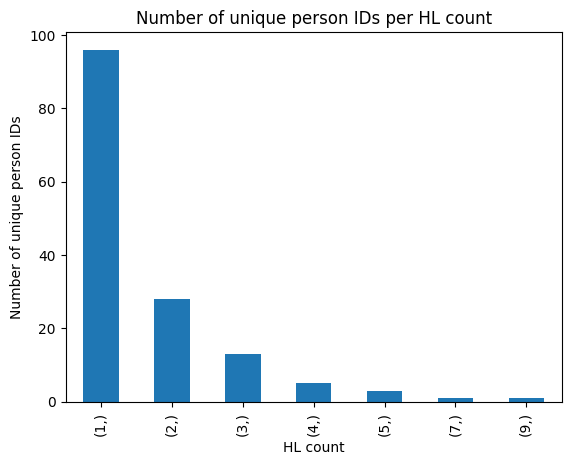

In [6]:
attack.run_full_attack(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf, city='berlin')